In [1]:
# No olvidar que en "google colab" hay que instalar qiskit

########################
# Instala versión 0.45.2
########################
# Importante, poner qiskit-aer en la misma linea de "pip install" para que coja la versión adecuada
try:
    import google.colab
    print("In colab, let's install things...")
    #
    !pip install qiskit[visualization]==0.45.2 qiskit-aer qiskit-ibm-runtime
except ImportError:
    print("NOT in colab")

NOT in colab


In [2]:
import qiskit
from qiskit_aer import AerSimulator
import qiskit.tools.jupyter
%qiskit_version_table
print('Qiskit version', qiskit.__version__)
import numpy
import scipy
print("Numpy version", numpy.__version__)
print("Scipy version", scipy.__version__)

Qiskit version 0.45.2
Numpy version 1.26.4
Scipy version 1.13.1


In [3]:
from IPython.display import display, Latex, Markdown
from matplotlib import pyplot as plt
import scipy.linalg as la
import numpy as np

<a id='sec_Notebooks_Fundamentos'></a>
# Fundamentos de Mecánica Cuántica
$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\ketbra}[2]{| #1\rangle \langle #2|} $
$ \newcommand{\tr}{{\rm Tr}\,} $
$ \newcommand{\Tr}{{\rm Tr}\,} $
$ \newcommand{\i}{{\color{blue} i}} $ 
$ \newcommand{\Hil}{{\cal H}} $
$ \newcommand{\V}{{\cal V}} $

## Evolución temporal de un sistema de dimensión 2

<!-- div class="alert alert-block alert-success" -->
<div>
La evolución de la ecuación de estado a lo largo del tiempo dado un hamiltoniano $H$ independiente del tiempo viene dada por

$$
\boxed{\psi(t)= e^{{\Large \frac{-i}{\hbar}} t H} |\psi_0\rangle \text{, donde para t=0:} \,\, |\psi_0\rangle=\psi(0)}
$$

Escribe una función <i>psi(t,psi_0_ket,H)</i> que reciba como argumentos el array <i>psi0</i> de componentes de $|{\psi(0)}\rangle$, una matriz hermítica <i>H</i>, y un valor de <i>t</i>, y devuelva un vector columna correspondiente a $|{\psi(t)}\rangle$. Considera $\hbar=1$.

</div>

In [4]:
# Nuestra constante de Plank "h barra = h/(2*pi)"
hbar = 1

def expH(t, H):
    # Retornamos la exponencial de la ecuación de ondas
    #    |\psi(t)> = e^{-i t H/hbar} |\psi(0)> = U |\psi(0) >
    # o sea,
    #    U = e^{-i t H/hbar}
    #
    U = la.expm(-1j*t*H/hbar);
    return U

def psi(t, psi_0_ket, H):
    # Retornamos la función de ondas
    #    |\psi(t)> = e^{-i t H/hbar} |\psi(0)> = U |\psi(0) >
    #
    lpsi = len(psi_0_ket)
    lH = H.shape[0]
    assert lpsi == lH # Chequear dimensión

    # |\psi(t)> = e^{-i t H} |\psi(0) >
    # U = e^(- 1j*t*H);
    U = expH(t, H)
    psi_t_ket = U @ psi_0_ket
   
    return psi_t_ket

Ahora:
- Partiendo del instante 0 y para un intervalo de tiempo razonable, muestrea los valores de la probabilidad de $p_0$, $p_1$ de medir $|{0}\rangle$ o $\ket{1}$ respectivamente, para posteriormente graficarlos
- Así mismo muestrea también el valor promedo del Hamiltoniano en cada instante $\langle H\rangle_{\Psi(t)}$
- Se construirán 4 listas, una con valores equiespaciados del intervalo de tiempo elegido; otras dos con los valores respectivamente, de probabilidad de medir 0 o 1 en dichos intantes de tiempo; y otra más con el valor esperado del Hamiltoniano

Se considerará que:
- El Hamiltoniano es una matrix aleatoria hermítica de dimensiones 2x2
- El valor inicial del estado del sistema, para $t=0$, es: $|\Psi(t=0)\rangle=|\Psi_0\rangle=|{0}\rangle$

In [5]:
# Vectores |0> y |1> de la base computacional por si hicieran falta
zero_ket = np.array([[1], [0]])
zero_bra = zero_ket.transpose() # alternativa: zero_bra = zero_ket.reshape((1,2))
one_ket = np.array([[0], [1]])
one_bra = one_ket.transpose()

# Construir un Hamiltoniano aleatorio (matriz hermitiana)
sigma = 5  # Normal random generation: N(mu,sigma) = sigma*N(0,1)+mu
A = np.round(sigma*np.random.randn(2,2) + sigma*np.random.randn(2,2)*1j, 2)
H = (A + A.transpose().conjugate())/2
print('H=', H)

# Fijamos estado inicial
psi0 = zero_ket

H= [[-5.75 +0.j    2.145+1.25j]
 [ 2.145-1.25j -2.73 +0.j  ]]


In [6]:
# Vamos a estimar la frecuencia asociado al Hamiltoniano para
# que luego las gráficas tengan un mejor aspecto
#
# Estimación de la frecuencia asociada al hamiltoniano, como
# e^(jwt)=cos(wt)+jsin(wt) usamos el máximo de los elementos
freq = np.max(np.abs(H))/2/np.pi/hbar
T=1/freq
print("Estimación de frecuencia={0:.2f}, w=2*pi*f={1:.2f}, T={2:.2f}".format(freq, 2*np.pi*freq, T))

Estimación de frecuencia=0.92, w=2*pi*f=5.75, T=1.09


In [7]:
# Elegimos aproximadamente N periodos, con samples muestras por periodo
N = 4; samples = 128
t = np.linspace(0, T*N, samples*N)  # time axis
print("#samples="+str(len(t)))

#samples=512


In [8]:
# Muestreo de las probabilidades en los instantes elegidos
# en la lista t

# Valores de |Psi(t)>
psi_t_ket = [psi(xt, psi0, H) for xt in t] # |psi(t)>
# Valores de <Psi(t)|
psi_t_bra = [ket.conjugate().transpose() for ket in psi_t_ket]  # <psi(t)|

# Probabilidades (lo quiero en formato lista)
psi_t_prob0 = [np.abs(psi(xt, psi0, H))[0][0]**2 for xt in t] # |a0|^2
psi_t_prob1 = [np.abs(psi(xt, psi0, H))[1][0]**2 for xt in t] # |a1|^2
 
# Valor esperado de H en función del tiempo (esperanza matemática):
#   <H>(t) = <psi(t) | H | psi(t)>
psi_t_bra_H_ket = [ np.real(psi_t_bra[idx] @ H @ psi_t_ket[idx])[0][0].item() for idx in range(0,len(t)) ]

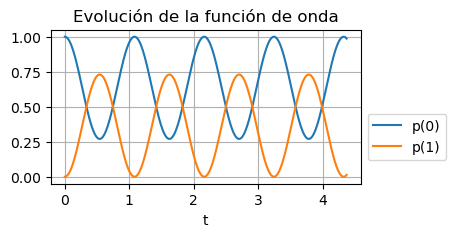

In [9]:
# Vamos a graficar las probabilidades
plt.figure(figsize=(4, 2))
plt.plot(t, psi_t_prob0, label='p(0)')
plt.plot(t, psi_t_prob1, label='p(1)')
plt.title('Evolución de la función de onda')
plt.xlabel('t')
plt.grid(True, which='both')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()
#display(plt)

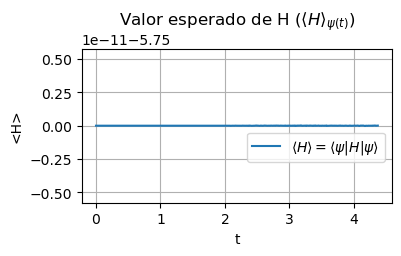

In [10]:
# Grafiquemos el valor medio
plt.figure(figsize=(4, 2))
plt.plot(t, psi_t_bra_H_ket, label=r'$\langle H\rangle=\langle \psi|H|\psi\rangle$')
plt.title(r'Valor esperado de H ($\langle H\rangle_{\psi(t)}$)')
plt.xlabel('t')
plt.ylabel('<H>')
plt.grid(True, which='both')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()
#display(plt)

<!-- div class="alert alert-block alert-success" -->
<div style="background-color:#c8e6c9">
<hr>    
<b>Ejercicio:</b>

Repite las gráficas  de probabilidad considerando la siguiente definición alternativa de las probabilidades (cuadrado de la amplitud de la proyección sobre los elementos de la base computacional):
- $p_0 = | \langle 0 | \Psi(t) \rangle|^2$
- $p_1 = | \langle 1 | \Psi(t) \rangle|^2$

Comprueba visualmente que se obtiene las mismas gráficas
<hr>
</div>

Analicemos la relación entre el valor medio $\langle H\rangle_\Psi $ y la descomposición espectral del Hamiltoniano $H$

In [11]:
# Autovalores y autovectores de H
el,ev = la.eig(H)
el = np.real(el) # quitar parte imaginaria ya que DEBE ser despreciable (H hermitiana),
                 # puede aparecer una componente residual por errores numéricos
eigval0 = el[0]
eigval1 = el[1]
elmax = np.max(el) 
elmin = np.min(el)
eigvec0 = ev[:,0].reshape(2,1) #ndarray
eigvec1 = ev[:,1].reshape(2,1)

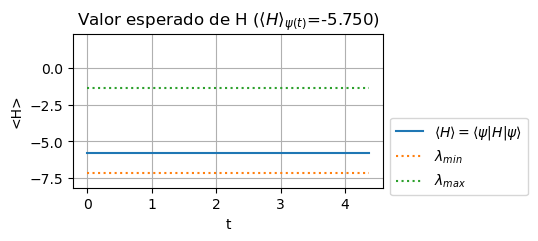

In [12]:
# Grafiquemos el valor medio con los autovalores
Havg = psi_t_bra_H_ket[0]   # El valor medio es constante, tomemos el primero
plt.figure(figsize=(4, 2))
plt.plot(t, psi_t_bra_H_ket, label=r'$\langle H\rangle=\langle \psi|H|\psi\rangle$')
plt.plot(t, elmin*np.ones(t.shape), linestyle=':' , label=r'$\lambda_{min}$')
plt.plot(t, elmax*np.ones(t.shape), linestyle=':' , label=r'$\lambda_{max}$')
plt.title(r'Valor esperado de H ($\langle H\rangle_{\psi(t)}$=%.3f)'%Havg)
plt.xlabel('t')
plt.ylabel('<H>')
plt.ylim(-np.abs(elmin)-1, np.abs(elmax)+1)
plt.grid(True, which='both')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

Óbservese que el valor esperado de H debe estár comprendido entre sus valores propios que son reales. 

Se puede ver esto numéricamente 
$$\langle H \rangle 
   = \sum_k \lambda_k  \text{prob}\,(\lambda_k) 
   =   \lambda_0 \,\text{prob}(\lambda_0)  +  \lambda_1 \,\text{prob}(\lambda_1)
$$

siendo $\text{prob}({\lambda_i}) = | \langle\lambda_i| \Psi_0\rangle|^2$, es decir, **la probabilidad de obtener** una medición igual a **un autovalor** es el **cuadrado de la amplitud de la proyección** del estado en un instante **sobre el autovector** asociado a dicho valor propio. 

Comprobémoslo para un instante de tiempo en particular, por ejemplo $t=0$ (¡debe de cumplirse para cualquier instante!)

In [13]:
# Probabilidades del estado psi0=|0> sobre los autovectores,
# |<eigenvec_lambda0|0>|^2 -> matriz 1x1 -> extraer escalar
psi_t_prob_lambda0 = np.abs(eigvec0.transpose() @ psi0)[0][0].item()**2
# |<eigenvec_lambda1|0>|^2 -> matriz 1x1 -> extraer escalar
psi_t_prob_lambda1 = np.abs(eigvec1.transpose() @ psi0)[0][0].item()**2

# Media usando estas probabilidades sobre los autovalores: sum(lambda_i * |lambda_i>):
eigenvalue_avg = psi_t_prob_lambda0 * eigval0 + psi_t_prob_lambda1 * eigval1

display(Markdown(r"$\displaystyle\sum_{i=0}^{1}{\lambda_i *p(\lambda_i)} =$" 
              + "%.3f"%eigenvalue_avg
              + r" (debe coindidir con $\langle H\rangle$)"))


$\displaystyle\sum_{i=0}^{1}{\lambda_i *p(\lambda_i)} =$-5.750 (debe coindidir con $\langle H\rangle$)

<div style="background-color:#c8e6c9">
<hr>
<b>Ejercicio:</b>
    
Modifica el código anterior, moviendo el cálculo de los autovectores de $H$, justo después de generar $H$ aleatoriamente, para poderlos usar como valor inicial del sistema.

Y en lugar de tomar como valor inicial $|0\rangle$, toma como valor inicial de $\Psi$ para $t=0$ uno de los autovectores, es dedir  $|\Psi_0\rangle= |\lambda_i\rangle$.

Observa las gráficas que se obtienen en este caso cuando el estado inicial es un autoestado. ¿Es lo que se espera? ¿Qué significado tiene?
<hr>
</div>

<!-- div class="alert alert-block alert-success" -->
<div style="background-color:#c8e6c9">    
<hr>
<b>Ejercicio:</b>

<b> <font size="+1"><span style="color:red">[OPCIONAL, PARA OPTAR A NOTA] </span></font></b>

Para el caso del que partíamos, con $|\Psi_0\rangle= |0\rangle$, utiliza la FFT para determinar la frecuencia de la onda de probalididades, por ejemplo la de la probabilidad de medir $|0\rangle$.

Sugerencia: elimina la componente continua de la señal de probabilidad, esto es su valor medio, antes de hacer la FFT ya que lo que nos interesa es el primer armónico.

Grafica dicha FFT, y comprueba visualmente que el primer armónico es correcto. 

**Encuentra la relación entre dicha frecuencia, los autovalores de H y la constante $\hbar$**. Comprueba que numéricamente es correcta dicha relación repitiendo el experimento para múltiples matrices $H$ aleatorias.
(Puedes además repetir las pruebas con diferentes valores de $\hbar$).

**¿Qué ley física guarda gran paralelismo con esta relación?**
<hr>
</div>